In [1]:
#data loading
import pandas as pd
predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Payments/Datasets/2payments_rund_10-90.csv', low_memory = False)

In [2]:
#-------------------------------------------------pre-processing--------------------------------------------------------------#

#convert amount and accountbalance to classes and assign a word to each interval  
import numpy as np

#automatic labels
import string


class LabelCategorizer:
    def __init__(self, base_word='cat'):
        self.initial = 1
        self._alphabet_index = 0
        self.base_word = base_word
        self.current_word = self.base_word
        self.shift = 0

    def __str__(self):
        return 'Class: Label Categorizer\nBase word: ' + self.base_word + '\nCurrent Word: ' + self.current_word

    def get_next_word(self):
        if self.initial:
            self.initial = 0
            return self.current_word

        if self.shift > 0:
            self.current_word = self.current_word[-1] + self.current_word[:-1]
            self.shift -= 1
        else:
            self.current_word = self.current_word + string.ascii_lowercase[self._alphabet_index]
            self._alphabet_index = (self._alphabet_index + 1) % len(string.ascii_lowercase)
            self.shift = len(self.current_word) - 1

        return self.current_word


#replacement of the old columns with the new ones with classes
def cutter(col, number, word, words_map):
    #make sure that only positives are assigned an interval
    col_min = max(predata[col].min(), 1)
    col_max = max(predata[col].max(), 1)

    bins_a = np.geomspace(float(col_min), float(col_max), num=number)
    bins_a[0] = bins_a[0] - 1
    bins_aux = bins_a[1:]
    bins_aux = np.append(bins_aux, bins_a[-1] + 1)
    bin_tuples = list(zip(bins_a, bins_aux))

    bins = pd.IntervalIndex.from_tuples(bin_tuples)

    #range of the intervals made
    labels_a = []

    a = LabelCategorizer(base_word=word)

    for _ in range(number):
        labels_a.append(a.get_next_word())

    x = pd.cut(predata[col].to_list(), bins=bins)
    x.categories = labels_a
    predata[col] = x

    for i in range(number):
        words_map[labels_a[i]] = bins[i]

    #columns to apply the conversion


columns = ['amount', 'accountbalance']

#number of intervals for each column
number_bins = [23, 21]

#base words assigned to each column on columns to apply the conversion
base_words = ['pink', 'red']

#get acess to the range of the interval based on the word that appears
values_map = {}

for i in range(len(columns)):
    cutter(columns[i], number_bins[i], base_words[i], values_map)

In [4]:
#bins amount
#transfers: 10m - 25.123 / 1M - 35.8775 / 2M - 37.3285 / 3M - 38.2194 / 4M - 38.818 / 5M - 39.3326 / gans - 26.3159 / imbalanced - 24.7233
#payments: 10m -  / 1M - 36.7452 / 2M - 38.2134 / 3M - 39.1709 / 4M - 39.8368 / 5M - 40.2234 / gans - 24.8089 / imbalanced - 22.5533

#bins accountbalance
#transfers: 10m - 24.6482 / 1M - 37.0555 / 2M - 38.5003 / 3M - 39.4439 / 4M - 40.1224 / 5M - 40.627 / gans - 25.734 / imbalanced - 23.9742
#payments: 10m - / 1M - 37.234 / 2M - 38.6645 / 3M - 39.651 / 4M - 40.2506 / 5M - 40.7402 / gans - 26.0935 / imbalanced - 20.7986

In [3]:
#assign the word negaccount for negative values of accountbalance  
aux = predata['accountbalance'].values

vacc = []

for elm in aux:
    if str(elm) == 'nan':
        vacc.append('negaccount')
    else:
        vacc.append(elm)
predata['accountbalance'] = vacc

In [9]:
#interval that a word corresponds to
#values_map['apbicndke']

Interval(34055.72399772817, 50124.37964687015, closed='right')

In [4]:
#convert hours to classes and assign a word to each interval  
bins_hour = [0, 4, 8, 12, 16, 20, 24]

#labels assigned to each interval
labels_hour = ['dawn', 'earlymorning', 'morning', 'afternoon', 'dusk', 'night']

predata['hour'] = list(pd.cut(predata['hour'], bins=bins_hour, labels=labels_hour, retbins=True, include_lowest=True)[0])

In [5]:
#map trusted_indicator values to words
ti_value_map = {
    '0.0': 'ntrusted',
    '0': 'ntrusted',
    '1.0': 'trusted',
    'unknown': 'tunknown'
}

predata['trusted_indicator'] = predata['trusted_indicator'].apply(lambda x: ti_value_map[x])

In [6]:
#add letter before number to distinguish between similar numbers from different columns
cols = ['entity', 'reference', 'iban_orig', 'iban_dest', 'ipaddress', 'clientid', 'week']

identifier = ['e', 'r', 'io', 'id', 'ip', 'c', 'w']

for col in range(len(cols)):
    predata[cols[col]] = predata[cols[col]].apply(lambda x: identifier[col] + str(x))

In [7]:
#convert binary and chains of numbers to specific words
def apply_map(df, col, target_map):
    df[col] = df[col].apply(lambda x: target_map.get(str(x)))


cols_maps = [('is_fraud', {'0': 'nfraud', '1': 'fraud'}),
             ('weekday', {'0': 'mon', '1': 'tue', '2': 'wed', '3': 'thu', '4': 'fri', '5': 'sat', '6': 'sun'}),
             ('month', {'1': 'jan', '2': 'feb', '3': 'mar', '4': 'apr', '5': 'may', '6': 'jun', '7': 'jul', '8': 'aug', 
                        '9': 'sep', '10': 'oct', '11': 'nov', '12': 'dec'})]

for comb in cols_maps:
    apply_map(predata, comb[0], comb[1])

In [8]:
#make fraud column as the center column
new_order = ['canal', 'operativa', 'clientid', 'entity', 'reference', 'trusted_indicator', 'iban_orig', 'iban_dest',
             'amount', 'is_fraud', 'accountbalance', 'ipaddress', 'browser_family', 'os_family', 'hour', 'week', 'weekday',
             'month', 'device']

predata = predata[new_order]

In [9]:
#select data for train and test  
from sklearn.model_selection import train_test_split

#target column
y = predata['is_fraud']
predata.drop('is_fraud', axis=1)

#train and test
X_train, X_test, y_train, y_test = train_test_split(predata, y, stratify=y, test_size=0.3)

In [10]:
#function for conversion format
def convert_to_w2v_format(df):
    sentences = df.to_numpy()
    sentences_aux = [list(curr) for curr in sentences]
    sentences_series = pd.Series(sentences_aux)
    return sentences_series

In [11]:
#for entering the model
sentences_series = convert_to_w2v_format(X_train)

In [12]:
#for the test metrics
X_test_np = X_test.copy()
sentences_series_np_test = convert_to_w2v_format(X_test_np)

In [13]:
#for the train metrics
X_train_np = X_train.copy()
sentences_series_np_train = convert_to_w2v_format(X_train_np)

In [14]:
#-----------------------------------------------------training----------------------------------------------------------------#

#inicialization and training word2vec 
import multiprocessing
from myWord2Vec import MyWord2Vec
from gensim.models.callbacks import CallbackAny2Vec

def training(sentences, dim, sample, negative, alpha, min_alpha):
    model = MyWord2Vec(
        sg = 1,  #skip-gram 
        workers = multiprocessing.cpu_count(),  #use all cores 
        vector_size = dim,  #dimension of the embedding space 
        window = 1,  #words befores and after the center word 
        sample = sample,  #whithout subsampling 
        min_count = 1,  #use every word 
        negative = negative,  #noise-words 
        hs = 0,  #negative sampling
        ns_exponent = 0.75,  #exponent to shape negative sampling 
        alpha = alpha,  #initial learning rate 
        min_alpha = min_alpha,  #final learning rate 
    )

    #vocabulary creation
    model.build_vocab(sentences)

    #model training
    model.train(sentences, epochs = 150, total_examples = model.corpus_count, compute_loss = True, callbacks = [])

    return model

In [15]:
#-----------------------------------------------------prediction-------------------------------------------------------------#

#update probv - vector with the parameters of a transaction
from scipy.special import softmax

def predictTransaction(my_model, m_cid, my_curr_cid, verbose):
    #obtain the representative vector of the clientid
    civ = my_model.wv.get_vector(m_cid)

    #multiplication of the clientid vector by the decode matrix (M2)  
    m2 = my_model.syn1neg
    
    #vector of len = vocab_size that softmax is applied to obtain the conditional probabilities 
    vout = softmax(np.dot(civ, m2.T))

    fraud_curr = my_curr_cid.copy()
    fraud_curr.append(my_model.wv.index_to_key.index('fraud'))

    nfraud_curr = my_curr_cid.copy()
    nfraud_curr.append(my_model.wv.index_to_key.index('nfraud'))

    #filter the vector to the transaction fields
    fraud_probv = sum(vout[fraud_curr])
    nfraud_probv = sum(vout[nfraud_curr])

    #print results if verbose True
    if verbose:
        print(f"Transaction: {my_curr_cid}\nFraud prob: {fraud_probv}\nNon Fraud prob: {nfraud_probv}")

    #threshold for false negatives
    # if fraud_probv > threshold: return 1

    if fraud_probv > nfraud_probv:
        return 1
    
    return 0

In [16]:
#prediction method   
def predict(model, X, verbose1, verbose2):
    #save the predictions made by the model in a list
    predictions = []

    #for each transaction (eval_row)
    for i, eval_row in enumerate(X, 1):

        #print transaction parameters if verbose1 True
        if verbose1:
            print(eval_row)

        #cid is always in position 2 of the array
        curr_cid = eval_row[2]

        #for each sentence_series creates a current list
        curr = []

        #if curr_cid is not known
        if curr_cid not in model.wv.index_to_key:
            #update model
            model.build_vocab([[curr_cid]], update=True)

        #filter the parameters associated with the transaction made by the specific clientid (civ)
        for x in eval_row:
            if x != curr_cid:
                if x in model.wv.index_to_key:
                    curr.append(model.wv.index_to_key.index(x))

                else:
                    #if the word is not known                        
                    #update model
                    model.build_vocab([[x]], update=True)
                    curr.append(model.wv.index_to_key.index(x))

        #sum each value on the array to obtain the final probability
        curr_prediction = predictTransaction(model, curr_cid, curr, verbose2)
        predictions.append(curr_prediction)

    return predictions

In [17]:
#convert true values for the train set to binary
y_train = [1 if elem == "fraud" else 0 for elem in y_train]

In [18]:
#convert true values of the test set to binary
y_test = [1 if elem == "fraud" else 0 for elem in y_test]

In [19]:
#grid-search
import os
from mlflow import log_metric, log_param, log_artifact
import mlflow
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

#create a hyperparameters dictionary 
dim = [2, 5]   
negative = [5, 10] #0 leads to not having the syn1neg property
alpha = [0.025, 0.035] 
min_alpha = [0.0001, 0.001] 
sample = [0, 0.001, 0.01]

#train the model 
i = 0
for d in dim:
    for n in negative:
        for a in alpha:
            for m in min_alpha:
                for s in sample:
                    i+=1
                    with mlflow.start_run(nested=True):

                        # Log params to mlflow
                        log_param("dim", d)
                        log_param("negative", n)
                        log_param("alpha", a)
                        log_param("min_alpha", m)
                        log_param("sample", s)

                        curr_model = training(sentences_series_np_train, dim = d, sample = s, negative = n, alpha = a, min_alpha = m)

                        #metrics for each combination - train
                        prevs_train = predict(curr_model, sentences_series_np_train, verbose1 = False, verbose2 = False)
                        precision_train, recall_train, fscore_train, _ = precision_recall_fscore_support(y_train, prevs_train, average='micro')
                        tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, prevs_train).ravel()
                        
                        log_param("precision_train", precision_train)
                        log_param("recall_train", recall_train)
                        log_param("f1_train", fscore_train)
                        log_param("tn_train", tn_train)
                        log_param("fp_train", fp_train)
                        log_param("fn_train", fn_train)
                        log_param("tp_train", tp_train)

                        #save current model
                        curr_model.save("trained_model.w2v")
                        log_artifact("trained_model.w2v")
                        os.remove("trained_model.w2v")

Validation loss decreased (inf --> 43184.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (43184.000000 --> 30352.515625).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (30352.515625 --> 28238.656250).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (28238.656250 --> 27544.031250).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (27544.031250 --> 26505.875000).  Saving model ...
Validation loss decreased (26505.875000 --> 26281.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (26281.875000 --> 25964.812500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping c

EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (16818.625000 --> 16578.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (16578.250000 --> 16566.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (16566.687500 --> 16407.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (16407.250000 --> 16383.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 ou

EarlyStopping counter: 14 out of 25
EarlyStopping counter: 15 out of 25
EarlyStopping counter: 16 out of 25
EarlyStopping counter: 17 out of 25
EarlyStopping counter: 18 out of 25
Validation loss decreased (22979.750000 --> 22803.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (22803.500000 --> 22655.250000).  Saving model ...
Validation loss decreased (22655.250000 --> 22556.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out

EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
Validation loss decreased (15814.375000 --> 15795.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (15795.750000 --> 15726.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (15726.500000 --> 15688.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 

EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Validation loss decreased (inf --> 40429.109375).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (40429.109375 --> 28656.593750).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (28656.593750 --> 27536.468750).  Saving model ...
Validation loss decreased (27536.468750 --> 27233.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (27233.875000 --> 26588.531250).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (26588.531250 --> 26020.906250).  Saving model ...
Validation loss decreased (26020.906250 --> 25672.250000

EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
Validation loss decreased (16414.750000 --> 16177.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
Validation loss decreased (16177.375000 --> 16162.250000).  Saving model ...
EarlyStopping counter: 1 out of 

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (22601.250000 --> 22528.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (22528.000000 --> 22410.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (22410.250000 --> 22289.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (22289.750000 --> 22202.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 ou

EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Validation loss decreased (21173.750000 --> 19766.500000).  Saving model ...
Validation loss decreased (19766.500000 --> 19694.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (inf --> 41458.160156).  Saving model ...
Validation loss decreased (41458.160156 --> 36431.652344).  Saving model ...
Validation loss decreased (36431.652344 --> 22763.007812).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (22763.007812 --> 20849.875000).  Saving model ...
EarlyStopping counter

EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
EarlyStopping counter: 15 out of 25
EarlyStopping counter: 16 out of 25
EarlyStopping counter: 17 out of 25
EarlyStopping counter: 18 out of 25
Validation loss decreased (23274.000000 --> 22996.750000).  Saving model ...
Validation loss decreased (22996.750000 --> 22814.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (22814.500000 --> 22733.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 

EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
Validation loss decreased (21155.812500 --> 20867.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (20867.750000 --> 20712.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
Validation loss decreased (20712.625000 --> 20641.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (206

Validation loss decreased (49667.937500 --> 48881.312500).  Saving model ...
Validation loss decreased (48881.312500 --> 48607.375000).  Saving model ...
Validation loss decreased (48607.375000 --> 48285.312500).  Saving model ...
Validation loss decreased (48285.312500 --> 47860.187500).  Saving model ...
Validation loss decreased (47860.187500 --> 47736.812500).  Saving model ...
Validation loss decreased (47736.812500 --> 47219.562500).  Saving model ...
Validation loss decreased (47219.562500 --> 47153.812500).  Saving model ...
Validation loss decreased (47153.812500 --> 47116.562500).  Saving model ...
Validation loss decreased (47116.562500 --> 47095.312500).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (47095.312500 --> 46914.500000).  Saving model ...
Validation loss decreased (46914.500000 --> 46809.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (46809.875000 --> 46560.750000).  Saving model ...
Valida

EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (19019.000000 --> 18715.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
EarlyStopping counter: 13 out of 25
EarlyStopping counter: 14 out of 25
EarlyStopping counter: 15 out of 25
EarlyStopping counter: 16 out of 25
EarlyStopping counter: 17 out of 25
EarlyStopping counter: 18 out of 25
EarlyStopping counter: 19 out of 25
EarlyStopping counter: 20 out of 25
EarlyStopping counter: 21 out of 25
EarlyStopping counter: 22 out of 25
EarlyStopping counter: 23 out of 25
EarlyStopping counter: 24 out of 2

EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (22598.218750 --> 21477.812500).  Saving model ...
Validation loss decreased (21477.812500 --> 21413.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (21413.250000 --> 20999.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (20999.687500 --> 20576.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 ou

EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (44421.750000 --> 44417.375000).  Saving model ...
Validation loss decreased (44417.375000 --> 44306.500000).  Saving model ...
Validation loss decreased (44306.500000 --> 44294.375000).  Saving model ...
Validation loss decreased (44294.375000 --> 44198.750000).  Saving model ...
Validation loss decreased (44198.750000 --> 44094.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (44094.500000 --> 43862.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (43862.000000 --> 41719.625000).  Saving model ...
Validation loss decreased (41719.625000 --> 40976.500000).  Saving model ...
Validation loss decreased (40976.500000 --> 40898.750000).  Saving model ...
Validation loss decreased (40898.750000 --> 40620.000000).  Sa

EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (20502.250000 --> 20211.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Validation loss decreased (20211.000000 --> 20186.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (20186.625000 --> 19629.500000).  Saving model ...
Validation loss decreased (19629.500000 --> 18750.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 o

EarlyStopping counter: 1 out of 25
Validation loss decreased (10693.000000 --> 10619.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (10619.750000 --> 10461.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (10461.625000 --> 10431.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (10431.000000 --> 10073.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 ou

EarlyStopping counter: 4 out of 25
Validation loss decreased (10577.750000 --> 10448.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Validation loss decreased (10448.250000 --> 10401.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (inf --> 56752.847656).  Saving model ...
Validation loss decreased (56752.847656 --> 42058.871094).  Saving model ...
Validation loss decreased (42058.871094 --> 36797.265625).  Saving model ...
Validation loss decreased (36797.265625 --> 34852.765625).  Saving model ...
Validation loss decreased (34852.765625 --> 32937.125000).  Saving model ...
Validation los

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (inf --> 58420.789062).  Saving model ...
Validation loss decreased (58420.789062 --> 41845.187500).  Saving model ...
Validation loss decreased (41845.187500 --> 37112.976562).  Saving model ...
Validation loss decreased (37112.976562 --> 23718.968750).  Saving model ...
Validation loss decreased (23718.968750 --> 22509.109375).  Saving model ...
Validation loss decreased (22509.109375 --> 21316.218750).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (21316.218750 --> 19415.562500).  Saving model ...
Validation loss decreased (19415.562500 --> 18563.390625).  Saving model ...
Validation loss decreased (18563.390625 --> 18149.281250).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (18149.281250 --> 16951.156250).  Saving model ...
EarlyStopping counter: 1 out 

EarlyStopping counter: 1 out of 25
Validation loss decreased (13848.562500 --> 13812.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (13812.187500 --> 13786.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (13786.875000 --> 13251.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (13251.375000 --> 13138.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (13138.250000 --> 12787.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (12787.750000 --> 12756.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (12756.875000 --> 12545.062500).  Saving model ...
Valida

EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (13112.125000 --> 13109.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (13109.750000 --> 12823.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (12823.625000 --> 12642.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (12642.875000 --> 12516.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (12516.500000 --> 12495.125000).  Saving model ...
EarlyStopping counte

EarlyStopping counter: 2 out of 25
Validation loss decreased (10591.875000 --> 10436.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (10436.500000 --> 10268.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
Validation loss decreased (10268.000000 --> 10180.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of

EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (10261.125000 --> 10240.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Validation loss decreased (10240.875000 --> 10187.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (10187.125000 --> 10080.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25

Validation loss decreased (inf --> 35736.554688).  Saving model ...
Validation loss decreased (35736.554688 --> 26819.769531).  Saving model ...
Validation loss decreased (26819.769531 --> 24149.902344).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (24149.902344 --> 20900.835938).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (20900.835938 --> 18267.359375).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (18267.359375 --> 16208.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (16208.750000 --> 15615.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (15615.187500 --> 14826.562500).  Saving model ...
Validation loss decreased (14826.562500 -->

EarlyStopping counter: 2 out of 25
Validation loss decreased (13196.781250 --> 13152.937500).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (13152.937500 --> 12569.687500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (12569.687500 --> 12564.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (12564.750000 --> 12111.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (12111.375000 --> 11836.062500).  Saving model ...
EarlyStopping counte

EarlyStopping counter: 5 out of 25
Validation loss decreased (12754.875000 --> 12674.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (12674.750000 --> 12559.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (12559.875000 --> 12321.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (12321.000000 --> 12310.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (12310.625000 --> 12278.125000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (12278.125000 --> 12186.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (12186.625000 --> 1217

Validation loss decreased (14763.750000 --> 14689.500000).  Saving model ...
Validation loss decreased (14689.500000 --> 14611.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (14611.750000 --> 14479.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
Validation loss decreased (14479.000000 --> 14304.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 o

EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (13270.500000 --> 13136.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (13136.250000 --> 13107.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 12 out of 25
Ear

Validation loss decreased (33060.781250 --> 31614.406250).  Saving model ...
Validation loss decreased (31614.406250 --> 30801.562500).  Saving model ...
Validation loss decreased (30801.562500 --> 29951.562500).  Saving model ...
Validation loss decreased (29951.562500 --> 29607.500000).  Saving model ...
Validation loss decreased (29607.500000 --> 29513.000000).  Saving model ...
Validation loss decreased (29513.000000 --> 28912.250000).  Saving model ...
Validation loss decreased (28912.250000 --> 28131.625000).  Saving model ...
Validation loss decreased (28131.625000 --> 27844.000000).  Saving model ...
Validation loss decreased (27844.000000 --> 27620.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (27620.187500 --> 27193.937500).  Saving model ...
Validation loss decreased (27193.937500 --> 27038.000000).  Saving model ...
Validation loss decreased (27038.000000 --> 26689.000000).  Saving model ...
Validation loss decreased (26689.000000 -

Validation loss decreased (17174.000000 --> 17010.187500).  Saving model ...
Validation loss decreased (17010.187500 --> 16781.437500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (16781.437500 --> 16444.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (16444.625000 --> 16294.000000).  Saving model ...
Validation loss decreased (16294.000000 --> 15930.375000).  Saving model ...
Validation loss decreased (15930.375000 --> 15860.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (15860.375000 --> 15823.000000).  Saving model ...
Validation loss decreased (15823.000000 --> 15792.500000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (15792.5

EarlyStopping counter: 3 out of 25
Validation loss decreased (16714.500000 --> 16609.000000).  Saving model ...
Validation loss decreased (16609.000000 --> 16525.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
Validation loss decreased (16525.875000 --> 15880.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (15880.250000 --> 15870.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (15870.250000 --> 15654.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counte

EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
Validation loss decreased (13882.250000 --> 13831.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
Validation loss decreased (13831.000000 --> 13791.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (13791.750000 --> 13783.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (13783.000000 --> 13636.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (13636.250000 --> 13533.000000).  Sa

Validation loss decreased (inf --> 78457.335938).  Saving model ...
Validation loss decreased (78457.335938 --> 54104.179688).  Saving model ...
Validation loss decreased (54104.179688 --> 48253.000000).  Saving model ...
Validation loss decreased (48253.000000 --> 43165.812500).  Saving model ...
Validation loss decreased (43165.812500 --> 40374.171875).  Saving model ...
Validation loss decreased (40374.171875 --> 38268.968750).  Saving model ...
Validation loss decreased (38268.968750 --> 37327.656250).  Saving model ...
Validation loss decreased (37327.656250 --> 35408.625000).  Saving model ...
Validation loss decreased (35408.625000 --> 34111.656250).  Saving model ...
Validation loss decreased (34111.656250 --> 33317.187500).  Saving model ...
Validation loss decreased (33317.187500 --> 32603.812500).  Saving model ...
Validation loss decreased (32603.812500 --> 31741.281250).  Saving model ...
Validation loss decreased (31741.281250 --> 31291.062500).  Saving model ...
Validati

EarlyStopping counter: 1 out of 25
Validation loss decreased (27109.312500 --> 18457.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (18457.000000 --> 17865.562500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (17865.562500 --> 17615.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (17615.250000 --> 17527.062500).  Saving model ...
Validation loss decreased (17527.062500 --> 17371.187500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (17371.187500 --> 17116.562500).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping

EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (14984.875000 --> 14767.625000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Validation loss decreased (14767.625000 --> 14613.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (14613.000000 --> 14541.375000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (14541.375000 --> 14498.000000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Validation loss decreased (14498.000000 --> 14319.875000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counte

EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
Validation loss decreased (15702.000000 --> 15560.750000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Validation loss decreased (15560.750000 --> 15526.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
Validation loss decreased (15526.250000 --> 15505.250000).  Saving model ...
Validation loss decreased (15505.250000 --> 15317.250000).  Saving model ...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
Validation loss decreased (15317.250000 --> 15260.250000).  S

In [ ]:
#apply the prediction method for the train set
#predict(model, X_train_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values for the train set
#y_train

In [ ]:
#metrics for the train set
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_train
prevs = predict(model, X_train_np.values, verbose1 = False, verbose2 = False, shouldBe = trs)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs,prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

In [ ]:
#apply the prediction method for the test set
#predict(model, X_test_np.values, verbose1=True, verbose2=True)

In [ ]:
#true values of the test set
#set(y_test)

In [20]:
#load the ideal model
import gensim.models.word2vec as w2v

model = w2v.Word2Vec.load(r'C:/Users/BeatrizCarvalho/Music/payments-imbalanced/mlruns/0/a299c32c8dd34eb99e0dd856c2dbbe6d/artifacts/trained_model.w2v')

Transaction: [6, 3, 119, 7861, 1, 7862, 0, 26, 2, 29, 7863, 10, 8, 56, 95, 19, 37, 11]
Fraud prob: 0.0021475706744240597
Non Fraud prob: 0.0021812725135532673
Transaction: [15, 3, 111, 205, 1, 207, 0, 77, 46, 52, 303, 7, 5, 12, 107, 21, 37, 4]
Fraud prob: 0.027407463442606105
Non Fraud prob: 0.02740746464583719
Transaction: [15, 42, 47, 7865, 1, 7866, 0, 420, 2, 134, 7867, 90, 5, 12, 76, 17, 34, 4]
Fraud prob: 0.0021876411738048773
Non Fraud prob: 0.002228391451353673
Transaction: [6, 28, 50, 7869, 1, 7870, 0, 23, 2, 20, 7871, 10, 8, 56, 105, 25, 43, 11]
Fraud prob: 0.0018912654450105038
Non Fraud prob: 0.0019311306095914915
Transaction: [9, 28, 115, 7873, 1, 7874, 0, 23, 2, 139, 7875, 7, 5, 12, 95, 22, 34, 4]
Fraud prob: 0.0018783228297252208
Non Fraud prob: 0.0019150952866766602
Transaction: [15, 3, 163, 7877, 1, 7878, 0, 26, 2, 52, 7879, 7, 5, 13, 76, 17, 34, 4]
Fraud prob: 0.0023135193587222602
Non Fraud prob: 0.0023162525139923673
Transaction: [9, 3, 111, 411, 1, 7881, 0, 77, 46, 

Transaction: [6, 28, 50, 8043, 51, 8044, 0, 23, 2, 69, 8045, 10, 8, 56, 86, 19, 41, 11]
Fraud prob: 0.0025937617210729513
Non Fraud prob: 0.002626923374918988
Transaction: [6, 3, 81, 8047, 1, 8048, 0, 24, 2, 52, 8049, 16, 27, 14, 83, 17, 38, 18]
Fraud prob: 0.0026222960295854136
Non Fraud prob: 0.002619679282361176
Transaction: [9, 3, 65, 8051, 1, 8052, 0, 30, 2, 69, 8053, 7, 5, 32, 95, 19, 37, 4]
Fraud prob: 0.0019741157557291444
Non Fraud prob: 0.0020078984161955304
Transaction: [6, 3, 81, 8055, 1, 8056, 0, 24, 2, 33, 8057, 10, 8, 12, 95, 45, 37, 11]
Fraud prob: 0.0027232182474108413
Non Fraud prob: 0.0027195860748179257
Transaction: [9, 28, 115, 8059, 1, 8060, 0, 23, 2, 144, 8061, 7, 8, 12, 99, 22, 48, 18]
Fraud prob: 0.004133754824579228
Non Fraud prob: 0.0035499085861374624
Transaction: [6, 3, 191, 8063, 1, 8064, 0, 26, 2, 20, 8065, 10, 8, 56, 62, 25, 36, 11]
Fraud prob: 0.0019472331478027627
Non Fraud prob: 0.0019831629615509883
Transaction: [6, 28, 6442, 8067, 1, 8068, 0, 26, 2,

Transaction: [15, 3, 193, 8235, 1, 8236, 0, 26, 2, 35, 8237, 7, 5, 14, 143, 22, 38, 4]
Fraud prob: 0.003816404292592779
Non Fraud prob: 0.003745353053091094
Transaction: [6, 3, 65, 8239, 1, 8240, 0, 26, 2, 139, 8241, 16, 27, 13, 110, 21, 48, 18]
Fraud prob: 0.004377308127004653
Non Fraud prob: 0.0037332749634515494
Transaction: [15, 3, 65, 8243, 1, 8244, 0, 26, 2, 121, 8245, 7, 5, 12, 88, 25, 34, 4]
Fraud prob: 0.0034486043550714385
Non Fraud prob: 0.003433360903727589
Transaction: [6, 3, 432, 8247, 1, 8248, 0, 24, 2, 29, 8249, 10, 8, 12, 74, 49, 31, 11]
Fraud prob: 0.0034500418787501985
Non Fraud prob: 0.003387580649359734
Transaction: [15, 3, 66, 8250, 1, 805, 0, 67, 46, 60, 806, 7, 5, 13, 126, 17, 34, 4]
Fraud prob: 0.013110945847694441
Non Fraud prob: 0.013111138449149115
Transaction: [15, 127, 47, 123, 1, 280, 6073, 124, 46, 33, 292, 64, 5, 13, 91, 25, 40, 4]
Fraud prob: 0.013110122289342191
Non Fraud prob: 0.013110850921141531
Transaction: [6, 28, 129, 8252, 51, 8253, 0, 23, 2, 5

Transaction: [6, 3, 333, 8425, 1, 8426, 0, 44, 2, 39, 8427, 16, 27, 56, 116, 45, 40, 18]
Fraud prob: 0.0019705180275195744
Non Fraud prob: 0.001999248142965371
Transaction: [9, 120, 7627, 8429, 1, 8430, 0, 30, 2, 20, 8431, 7, 5, 12, 83, 19, 38, 4]
Fraud prob: 0.002346621549804695
Non Fraud prob: 0.0023582596913911402
Transaction: [6, 3, 8433, 8434, 1, 8435, 0, 26, 2, 20, 8436, 16, 27, 32, 112, 49, 37, 18]
Fraud prob: 0.0033231672532565426
Non Fraud prob: 0.0032988419952744152
Transaction: [6, 3, 59, 8437, 1, 6811, 0, 54, 2, 39, 8438, 10, 8, 13, 96, 45, 43, 11]
Fraud prob: 0.01497172005417552
Non Fraud prob: 0.014972067090371301
Transaction: [6, 3, 158, 8440, 1, 8441, 0, 54, 2, 29, 8442, 10, 8, 12, 107, 21, 37, 11]
Fraud prob: 0.0028280502519919537
Non Fraud prob: 0.0027832649866468273
Transaction: [6, 3, 104, 8444, 1, 8445, 0, 44, 2, 53, 8446, 10, 8, 12, 93, 17, 40, 11]
Fraud prob: 0.0036620049795601517
Non Fraud prob: 0.003548507302184589
Transaction: [9, 42, 58, 8448, 1, 8449, 0, 24,

Transaction: [6, 3, 149, 8622, 1, 8623, 0, 54, 2, 35, 8624, 10, 8, 32, 94, 21, 40, 11]
Fraud prob: 0.0024031518696574494
Non Fraud prob: 0.00236658715584781
Transaction: [6, 3, 65, 8626, 1, 8627, 0, 26, 2, 53, 8628, 10, 8, 13, 84, 17, 37, 11]
Fraud prob: 0.0019373056129552424
Non Fraud prob: 0.0019582025342970155
Transaction: [9, 3, 70, 8630, 51, 8631, 0, 24, 2, 35, 8632, 7, 5, 13, 73, 19, 31, 4]
Fraud prob: 0.002552312613261165
Non Fraud prob: 0.002580085794761544
Transaction: [15, 3, 135, 8634, 1, 8635, 0, 63, 2, 35, 8636, 7, 5, 12, 105, 22, 43, 4]
Fraud prob: 0.001438155620235193
Non Fraud prob: 0.0014707788068335503
Transaction: [15, 113, 47, 8638, 1, 8639, 0, 67, 2, 35, 8640, 90, 5, 12, 106, 19, 43, 4]
Fraud prob: 0.0023679826153966133
Non Fraud prob: 0.0023017037638055626
Transaction: [9, 3, 1381, 8642, 1, 8643, 0, 24, 2, 52, 8644, 7, 5, 14, 101, 17, 61, 4]
Fraud prob: 0.0037396555635496043
Non Fraud prob: 0.0037247842337819748
Transaction: [9, 3, 133, 2739, 1, 295, 0, 146, 46, 5

Transaction: [6, 3, 81, 8813, 1, 8814, 0, 26, 2, 35, 8815, 16, 27, 32, 116, 21, 40, 18]
Fraud prob: 0.0018450817497068783
Non Fraud prob: 0.0018272018551215297
Transaction: [6, 3, 59, 4679, 1, 138, 0, 30, 46, 35, 219, 10, 8, 13, 83, 17, 38, 11]
Fraud prob: 0.033701541086319106
Non Fraud prob: 0.03370154108851457
Transaction: [6, 3, 186, 8817, 51, 8818, 0, 30, 2, 29, 8819, 16, 27, 12, 102, 22, 41, 18]
Fraud prob: 0.0015403347861138172
Non Fraud prob: 0.0015683357923990116
Transaction: [9, 42, 58, 8821, 1, 8822, 0, 44, 2, 33, 8823, 10, 5067, 13, 122, 25, 36, 4]
Fraud prob: 0.0017010128931360669
Non Fraud prob: 0.0017291438598476816
Transaction: [9, 3, 199, 8825, 51, 8826, 0, 26, 2, 39, 8827, 7, 5, 12, 103, 17, 38, 4]
Fraud prob: 0.002597781982331071
Non Fraud prob: 0.0026180154382018372
Transaction: [6, 3, 59, 251, 1, 138, 0, 24, 46, 35, 173, 10, 8, 56, 85, 45, 38, 11]
Fraud prob: 0.033369679174384326
Non Fraud prob: 0.03336967917655818
Transaction: [6, 3, 104, 8829, 1, 8830, 0, 24, 2, 2

Transaction: [15, 113, 47, 9008, 1, 9009, 0, 63, 2, 92, 9010, 64, 5, 12, 100, 21, 48, 4]
Fraud prob: 0.0017532998954266077
Non Fraud prob: 0.001783452667950769
Transaction: [6, 42, 58, 9012, 1, 9013, 0, 55, 2, 33, 9014, 10, 8, 14, 109, 21, 43, 11]
Fraud prob: 0.0019328141388541553
Non Fraud prob: 0.0019427683910180349
Transaction: [9, 42, 58, 9016, 1, 9017, 0, 44, 2, 92, 9018, 7, 5, 32, 73, 17, 31, 4]
Fraud prob: 0.0017049599755409872
Non Fraud prob: 0.0017326928245893214
Transaction: [6, 3, 59, 413, 1, 138, 0, 30, 46, 35, 254, 10, 8, 12, 85, 19, 38, 11]
Fraud prob: 0.02884962452634379
Non Fraud prob: 0.02884962452822318
Transaction: [9, 3, 9020, 9021, 1, 9022, 0, 24, 2, 29, 9023, 57, 5, 14, 96, 25, 43, 4]
Fraud prob: 0.001551048088913376
Non Fraud prob: 0.0015767821787449066
Transaction: [9, 3, 347, 9025, 51, 9026, 0, 26, 2, 35, 9027, 57, 5, 14, 140, 45, 61, 4]
Fraud prob: 0.0020141844543104526
Non Fraud prob: 0.0019932787654397544
Transaction: [9, 3, 186, 9029, 1, 9030, 0, 30, 2, 89,

Transaction: [9, 3, 119, 9205, 1, 9206, 0, 44, 2, 20, 9207, 57, 68, 13, 86, 21, 41, 4]
Fraud prob: 0.003188400274666492
Non Fraud prob: 0.0028477544910856523
Transaction: [6, 28, 50, 9209, 1, 9210, 0, 26, 2, 39, 9211, 10, 8, 32, 97, 19, 36, 11]
Fraud prob: 0.0014755373094885726
Non Fraud prob: 0.0015062590064189862
Transaction: [9, 3, 3693, 9213, 1, 9214, 0, 44, 2, 20, 9215, 64, 5, 75, 82, 21, 34, 4]
Fraud prob: 0.003528294852003455
Non Fraud prob: 0.003020414849743247
Transaction: [6, 3, 87, 9217, 51, 9218, 0, 54, 2, 29, 9219, 10, 8, 13, 116, 21, 40, 11]
Fraud prob: 0.0023933460979606025
Non Fraud prob: 0.0024219942242780235
Transaction: [9, 3, 70, 9221, 1, 9222, 0, 26, 2, 52, 9223, 7, 5, 13, 108, 22, 41, 4]
Fraud prob: 0.004351901468908181
Non Fraud prob: 0.004224425731081283
Transaction: [6, 3, 171, 9225, 165, 9226, 0, 23, 2, 33, 9227, 10, 8, 12, 74, 21, 31, 11]
Fraud prob: 0.002549682954850141
Non Fraud prob: 0.0025510130944894627
Transaction: [15, 3, 204, 9229, 1, 9230, 0, 26, 2, 

Transaction: [9, 3, 377, 9409, 1, 9410, 0, 44, 2, 39, 9411, 7, 8, 32, 147, 19, 61, 18]
Fraud prob: 0.003337703106808476
Non Fraud prob: 0.003246189677156508
Transaction: [9, 28, 253, 9413, 51, 9414, 0, 26, 2, 39, 9415, 7, 5, 13, 72, 17, 31, 4]
Fraud prob: 0.003068202371650841
Non Fraud prob: 0.002979912889713887
Transaction: [6, 3, 199, 9417, 1, 9418, 0, 26, 2, 39, 9419, 10, 8, 13, 71, 21, 41, 11]
Fraud prob: 0.003032963337318506
Non Fraud prob: 0.0029901006564614363
Transaction: [6, 3, 9300, 9421, 1, 9422, 0, 23, 2, 144, 9423, 10, 8, 12, 76, 22, 34, 11]
Fraud prob: 0.0021244412600935902
Non Fraud prob: 0.0020289414933358785
Transaction: [6, 28, 50, 9425, 1, 9426, 0, 54, 2, 39, 9427, 16, 27, 56, 116, 19, 40, 18]
Fraud prob: 0.001786432566404983
Non Fraud prob: 0.0018178388190790429
Transaction: [15, 3, 9429, 9430, 1, 9431, 0, 63, 2, 33, 9432, 7, 5, 14, 105, 19, 43, 4]
Fraud prob: 0.0012222591431054752
Non Fraud prob: 0.0012498908208726789
Transaction: [6, 3, 9434, 9435, 1, 9436, 0, 24,

Transaction: [6, 28, 50, 9613, 1, 9614, 0, 44, 2, 121, 9615, 16, 27, 13, 79, 17, 36, 11]
Fraud prob: 0.0027858983448822983
Non Fraud prob: 0.0026090806422871538
Transaction: [6, 3, 59, 9616, 1, 154, 0, 23, 46, 39, 168, 10, 8, 12, 83, 25, 38, 11]
Fraud prob: 0.013729905001400165
Non Fraud prob: 0.01372990503905896
Transaction: [6, 3, 59, 9618, 1, 9619, 0, 26, 2, 39, 9620, 16, 27, 14, 107, 25, 37, 18]
Fraud prob: 0.003878409679600736
Non Fraud prob: 0.0037757342179247644
Transaction: [6, 3, 148, 9622, 1, 9623, 0, 26, 2, 39, 9624, 10, 8, 75, 107, 17, 37, 11]
Fraud prob: 0.001819251639972208
Non Fraud prob: 0.0018162885571655352
Transaction: [15, 3, 111, 241, 1, 9626, 0, 63, 46, 20, 8460, 7, 5, 12, 126, 17, 34, 4]
Fraud prob: 0.0028378058996167965
Non Fraud prob: 0.002850670578482095
Transaction: [6, 3, 119, 9628, 1, 9629, 0, 23, 2, 20, 9630, 10, 8, 32, 103, 25, 38, 11]
Fraud prob: 0.001968353941265377
Non Fraud prob: 0.001995806913328124
Transaction: [6, 28, 50, 9632, 1, 9633, 0, 26, 2, 5

Transaction: [9, 3, 7292, 9802, 1, 9803, 0, 26, 2, 35, 9804, 64, 5, 13, 76, 17, 34, 4]
Fraud prob: 0.003022636075911578
Non Fraud prob: 0.002988166750583332
Transaction: [15, 3, 9806, 9807, 1, 9808, 0, 63, 2, 92, 9809, 7, 5, 14, 74, 19, 31, 4]
Fraud prob: 0.0015325936437875498
Non Fraud prob: 0.0015594526266795583
Transaction: [9, 3, 9811, 9812, 51, 9813, 0, 63, 2, 20, 369, 7, 5, 12, 107, 19, 37, 4]
Fraud prob: 0.004723951424239203
Non Fraud prob: 0.00449983928410802
Transaction: [9, 3, 194, 9815, 1, 9816, 0, 26, 2, 53, 9817, 7, 5, 32, 97, 19, 36, 4]
Fraud prob: 0.0021252216101856902
Non Fraud prob: 0.002086837121169083
Transaction: [15, 42, 47, 9819, 1, 9820, 0, 30, 2, 35, 9821, 7, 5, 14, 106, 25, 43, 4]
Fraud prob: 0.002547323780163424
Non Fraud prob: 0.0025203991135640536
Transaction: [9, 3, 111, 162, 1, 9823, 0, 63, 46, 39, 9824, 7, 8, 32, 85, 25, 38, 18]
Fraud prob: 0.0014600188569602324
Non Fraud prob: 0.001464681479774299
Transaction: [6, 3, 104, 9826, 1, 9827, 0, 30, 2, 33, 982

Transaction: [9, 3, 9994, 9995, 1, 9996, 0, 26, 2, 60, 9997, 7, 5, 32, 88, 17, 34, 4]
Fraud prob: 0.003883315119310282
Non Fraud prob: 0.0030548896320397034
Transaction: [9, 3, 184, 9999, 1, 10000, 0, 23, 2, 29, 10001, 10, 5, 14, 97, 45, 36, 130]
Fraud prob: 0.0020913802327413578
Non Fraud prob: 0.002044776458205888
Transaction: [9, 28, 115, 10003, 51, 10004, 0, 26, 2, 89, 10005, 7, 5, 14, 110, 22, 48, 4]
Fraud prob: 0.0016236613887485873
Non Fraud prob: 0.0016517110602762841
Transaction: [6, 3, 164, 10007, 1, 10008, 0, 30, 2, 52, 10009, 16, 27, 32, 71, 45, 41, 18]
Fraud prob: 0.0033498887351015583
Non Fraud prob: 0.0033650397235760465
Transaction: [6, 3, 264, 10011, 1, 10012, 0, 30, 2, 53, 10013, 10, 8, 14, 97, 49, 36, 11]
Fraud prob: 0.0022470008698292077
Non Fraud prob: 0.002270470944495173
Transaction: [6, 3, 65, 10015, 1, 10016, 0, 24, 2, 20, 10017, 10, 8, 13, 100, 25, 48, 11]
Fraud prob: 0.0032945760467555374
Non Fraud prob: 0.0032673435416654684
Transaction: [15, 3, 5555, 10019,

Transaction: [9, 3, 87, 10187, 1, 10188, 0, 54, 2, 89, 10189, 7, 5, 13, 76, 19, 34, 4]
Fraud prob: 0.0026036082199425437
Non Fraud prob: 0.0024118237852235325
Transaction: [9, 3, 10191, 10192, 1, 10193, 0, 44, 2, 33, 10194, 7, 5, 13, 112, 17, 37, 4]
Fraud prob: 0.0031763489605509676
Non Fraud prob: 0.0029122061168891378
Transaction: [15, 3, 10196, 10197, 1, 10198, 0, 24, 2, 35, 10199, 90, 5, 13, 116, 25, 40, 4]
Fraud prob: 0.0032758115048636682
Non Fraud prob: 0.002996679271745961
Transaction: [15, 3, 159, 10201, 1, 10202, 0, 146, 2, 121, 10203, 7, 5, 13, 84, 19, 37, 4]
Fraud prob: 0.0026071913889609277
Non Fraud prob: 0.0026161344576394185
Transaction: [6, 3, 239, 10205, 1, 10206, 0, 24, 2, 29, 10207, 10, 8, 12, 143, 17, 38, 11]
Fraud prob: 0.001486988182477944
Non Fraud prob: 0.0015130294559639879
Transaction: [9, 3, 104, 10209, 1, 10210, 0, 24, 2, 33, 10211, 7, 5, 14, 170, 19, 61, 4]
Fraud prob: 0.0014463766456174199
Non Fraud prob: 0.001469780399929732
Transaction: [9, 3, 152, 1021

Transaction: [15, 127, 47, 123, 51, 10358, 10359, 55, 2, 121, 10360, 7, 5, 14, 84, 17, 37, 4]
Fraud prob: 0.002007922830671305
Non Fraud prob: 0.0020088394921913277
Transaction: [6, 3, 172, 10362, 1, 10363, 0, 30, 2, 33, 10364, 16, 27, 14, 62, 45, 34, 18]
Fraud prob: 0.0013905609175708378
Non Fraud prob: 0.0014102608165558195
Transaction: [15, 3, 163, 10366, 1, 10367, 0, 26, 2, 92, 10368, 7, 5, 13, 112, 21, 37, 4]
Fraud prob: 0.0035425331807346083
Non Fraud prob: 0.0035319758171681315
Transaction: [9, 3, 200, 10370, 1, 10371, 0, 26, 2, 52, 10372, 64, 5, 14, 105, 21, 43, 4]
Fraud prob: 0.0016704656663932838
Non Fraud prob: 0.0016810153392725624
Transaction: [9, 120, 151, 10374, 1, 10375, 0, 44, 2, 35, 10376, 7, 5, 12, 96, 21, 43, 4]
Fraud prob: 0.0017349160370940808
Non Fraud prob: 0.0017568376679264475
Transaction: [9, 3, 393, 10378, 1, 10379, 0, 24, 2, 52, 10380, 7, 5, 12, 62, 21, 36, 4]
Fraud prob: 0.0011712220730260015
Non Fraud prob: 0.0012016745658911532
Transaction: [6, 3, 135, 1

Transaction: [9, 3, 59, 10560, 1, 10561, 0, 23, 2, 39, 10562, 7, 8, 32, 109, 17, 43, 18]
Fraud prob: 0.003115701330898446
Non Fraud prob: 0.0027663824748742627
Transaction: [15, 3, 10564, 10565, 1, 10566, 0, 63, 2, 33, 10567, 7, 5, 13, 107, 22, 37, 4]
Fraud prob: 0.001883937879028963
Non Fraud prob: 0.0018929474790638778
Transaction: [9, 3, 81, 10569, 1, 10570, 0, 30, 2, 33, 10571, 7, 5, 12, 93, 17, 40, 4]
Fraud prob: 0.002887126374844229
Non Fraud prob: 0.0028548876398417633
Transaction: [15, 127, 47, 123, 1, 10573, 10574, 44, 2, 92, 10575, 7, 5, 14, 82, 22, 34, 4]
Fraud prob: 0.0016413195808127057
Non Fraud prob: 0.0016693308516551042
Transaction: [15, 3, 66, 10576, 1, 2344, 0, 124, 46, 121, 2345, 57, 5, 12, 116, 22, 40, 4]
Fraud prob: 0.0029977190785770644
Non Fraud prob: 0.0029977740851033427
Transaction: [9, 3, 149, 10578, 1, 10579, 0, 23, 2, 20, 10580, 7, 8, 32, 91, 19, 40, 18]
Fraud prob: 0.0025501689251541393
Non Fraud prob: 0.002391703894318198
Transaction: [6, 28, 50, 10582, 

Transaction: [15, 113, 47, 10757, 1, 10758, 0, 124, 2, 33, 10759, 7, 5, 12, 112, 22, 37, 4]
Fraud prob: 0.0015143702948989812
Non Fraud prob: 0.0015223514892568346
Transaction: [6, 3, 217, 10761, 51, 10762, 0, 63, 2, 52, 10763, 16, 27, 13, 118, 17, 48, 18]
Fraud prob: 0.0018841042347048642
Non Fraud prob: 0.0018704577614698792
Transaction: [9, 3, 65, 10765, 51, 10766, 0, 30, 2, 53, 10767, 7, 5, 12, 170, 25, 61, 4]
Fraud prob: 0.0012337798962107627
Non Fraud prob: 0.0012606870895979227
Transaction: [15, 3, 66, 181, 1, 202, 0, 67, 46, 92, 203, 7, 5, 12, 62, 19, 36, 4]
Fraud prob: 0.005015941520222511
Non Fraud prob: 0.005015941579997241
Transaction: [9, 3, 461, 10769, 1, 10770, 0, 23, 2, 98, 10771, 7, 5, 32, 100, 19, 48, 4]
Fraud prob: 0.0024314264046552125
Non Fraud prob: 0.0024526828710804693
Transaction: [6, 3, 59, 10772, 1, 138, 0, 24, 46, 35, 183, 10, 8, 13, 85, 25, 38, 11]
Fraud prob: 0.013172901783411753
Non Fraud prob: 0.013172901784249305
Transaction: [6, 3, 152, 10774, 1, 10775

Transaction: [6, 28, 50, 10947, 1, 10948, 0, 23, 2, 39, 10949, 10, 8, 14, 71, 25, 41, 11]
Fraud prob: 0.005424679948191624
Non Fraud prob: 0.00508835452637868
Transaction: [137, 3, 10951, 10952, 165, 10953, 0, 55, 2, 20, 136, 10, 8, 13, 74, 21, 31, 11]
Fraud prob: 0.002508503952412866
Non Fraud prob: 0.0024161647306755185
Transaction: [9, 3, 276, 10955, 1, 10956, 0, 24, 2, 39, 10957, 10, 8, 32, 122, 22, 36, 11]
Fraud prob: 0.0017654397925070953
Non Fraud prob: 0.0017411772241757717
accuracy: 0.4795673076923077
precision: 0.4795673076923077
recall: 0.4795673076923077
fscore: 0.4795673076923077
mcc: -0.2117512410404423
G-mean: 0.4795673076923077
[[390 366]
 [ 67   9]]
true negatives: 390
false positives: 366
false negatives: 67
true positives: 9
specifity: 0.5158730158730159


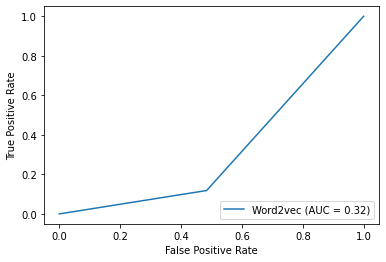

In [21]:
#metrics for the test set 
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_fscore_support, matthews_corrcoef, confusion_matrix, precision_recall_curve

trs = y_test
prevs = predict(model, X_test_np.values, verbose1 = False, verbose2 = True)

#precision, recall, f-score
precision, recall, fscore, support = precision_recall_fscore_support(trs, prevs, average = 'micro')

#precision - ratio tp / (tp + fp) - ability not to label a negative sample as positive
print('precision: {}'.format(precision))

#recall - ratio tp / (tp + fn) - ability to find all the positive samples - best is 1, worst is 0
print('recall: {}'.format(recall))

#fscore - weighted harmonic mean of the precision and recall - best is 1, worst is 0
print('fscore: {}'.format(fscore))

#matthews correlation coefficient - measure of the quality of binary classifications
#can be used even if the classes are of very different sizes - is in essence a correlation coefficient between -1 and +1
#+1 means perfect prediction, 0 an average random prediction, -1 an inverse prediction
mcc = matthews_corrcoef(trs, prevs)
print('mcc: {}'.format(mcc))

#g-mean - squared root of the product of the sensitivity and specificity - best is 1, worst is 0
print('G-mean:', (geometric_mean_score(trs, prevs, average = 'micro')))

#sensitivity - ability to predict true positives of each available category = recall

#confusion matrix    
print(confusion_matrix(trs, prevs))

#true positives, false positives, true negatives, false negatives
tn, fp, fn, tp = confusion_matrix(trs, prevs).ravel()

#true negatives
print('true negatives: {}'.format(tn))

#false positives
print('false positives: {}'.format(fp))

#false negatives
print('false negatives: {}'.format(fn))

#false positives
print('true positives: {}'.format(tp))

#specificity - ability to predict true negatives of each available category - recall of the negative class
specifity = tn / (tn + fp)
print('specifity: {}'.format(specifity))

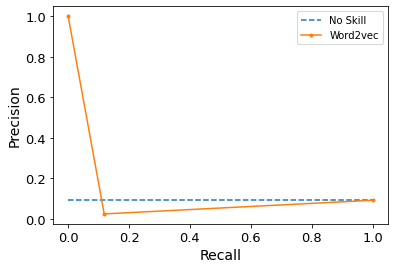

In [24]:
#precision-recall curve - compute precision-recall pairs for different probability thresholds
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(trs, prevs)

no_skill = trs.count(1) / len(trs)

#no-skill classifier
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')

#word2vec classifier
plt.plot(recall, precision, marker = '.', label = 'Word2vec')

#labels
plt.xlabel('Recall', fontsize = 14)
plt.ylabel('Precision', fontsize = 14)

#ticks
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

#legend
plt.legend()

#save
#plt.savefig(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Profiles/prcurve_transfers.png')

plt.show()